In [55]:
import os
import sys
import pandas as pd
from dotenv import load_dotenv
import re, json
import math, random
project_root = os.path.abspath("..")
sys.path.append(project_root) 
load_dotenv(os.path.join(project_root, ".env"))
api_key = os.getenv("GENAI_API_KEY")
# api_key

from utils.utils import (
    VisionLanguageModel,
    DataUtils,
    prepare_content,
    get_answers_chunked,
    make_gold_file_json,
    visualize_image,
    get_answers,
    postprocess_regex, 
    extract_answer, 
    save_answers_to_json,
)

In [9]:
vlm = VisionLanguageModel(api_key=api_key)

In [10]:
df = DataUtils.load_parquet("../eval_pqs/test.parquet")

Loaded DataFrame from ../eval_pqs/test.parquet, shape=(512, 11)


In [11]:
df

,type,grade,subject,language,chemical_structure,table,figure,graph,sample_id,image,answer_key
0,text,12,Physics,English,0,0,1,0,996d484a-43b4-4766-96ff-0747cf8fd841,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,None
1,text,12,Physics,English,0,0,1,0,57778143-868c-44f1-9d80-a6039c52fa1f,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,None
2,text,12,Physics,English,0,0,0,0,8e20d59f-4d57-41fd-ac84-a77df0ca2f87,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,None
3,text,12,Physics,English,0,0,1,0,a036bd0a-9dc5-4aff-8e3d-033f960dd1c7,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,None
4,text,12,Physics,English,0,0,0,0,d3faa9de-efe6-416b-b92f-26ed5025f233,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,None
...,...,...,...,...,...,...,...,...,...,...,...
507,text,12,Physics,English,0,0,0,0,373add4d-6fe3-46a6-b4d6-77b16c2665ba,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,None
508,text,12,Physics,English,0,0,0,0,61684a84-aef7-44e2-b56c-e36a768a0685,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,None
509,text,12,Physics,English,0,0,0,1,3ec5f05c-d14d-49b6-84d9-860eb805a651,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,None
510,text,12,Physics,English,0,0,0,1,29ed343a-a779-4e49-8ead-77bcdd54f1ce,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,None


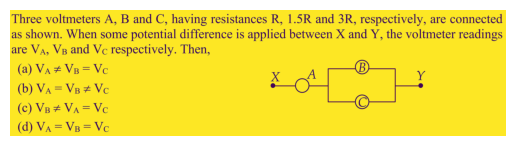

Predicted answer: Okay, let's analyze the image.

**0. Subject:** Physics, Circuit Analysis. The image contains a circuit diagram.

**1. Image Analysis:** The image shows a circuit with three voltmeters (A, B, and C) connected between points X and Y. Voltmeter A is in series with the parallel combination of voltmeters B and C. The resistances of A, B, and C are R, 1.5R, and 3R, respectively.

**2. Question Text Extraction:**  "Three voltmeters A, B and C, having resistances R, 1.5R and 3R, respectively, are connected as shown. When some potential difference is applied between X and Y, the voltmeter readings are VA, VB and Vc respectively. Then,"

**3. Extract Answer Choices:**
(a) VA ≠ VB = Vc
(b) VA = VB ≠ Vc
(c) VB ≠ VA = Vc
(d) VA = VB = Vc

**4. Additional Visual Elements:** Circuit diagram with voltmeters and labeled points X and Y.

**5. Multilingual/Multidomain Aspects:** Standard physics notation.

**6. Analyze the complete context and data provided:**  Voltmeter A is in series

In [12]:
row = df.iloc[1]
prompt, img = prepare_content(row, strict=False)
visualize_image(row["image"]["bytes"])

answer = vlm.get_answer(prompt, img, model="gemini-2.0-flash", strict=False, thinking=False)
print(f"Predicted answer: {answer}")

In [10]:
extract_answer(answer)

'A'

In [13]:
answers, failures = get_answers_chunked(
    df=df,
    vlm=vlm,
    model="gemini-2.5-flash-preview-04-17",
    strict=True, 
    step=10,
    thinking=True,
)
print(f"Got {len(answers)} answers, failed on rows: {failures}")


Error in _generate: 'NoneType' object has no attribute 'strip'
Attempt 1 for get_answer failed: 'NoneType' object has no attribute 'strip'. Retrying in 1.0s...
Error in _generate: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}
Attempt 1 for get_answer failed: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}. Retrying in 1.0s...
Error in _generate: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}
Attempt 1 for get_answer failed: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}. Retrying in 1.0s...
Error in _generate: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}
Attempt 1 for get_answ

In [14]:
answers

[{'id': '996d484a-43b4-4766-96ff-0747cf8fd841',
  'answer_key': 'B',
  'language': 'English'},
 {'id': '57778143-868c-44f1-9d80-a6039c52fa1f',
  'answer_key': 'D',
  'language': 'English'},
 {'id': '8e20d59f-4d57-41fd-ac84-a77df0ca2f87',
  'answer_key': 'C',
  'language': 'English'},
 {'id': 'a036bd0a-9dc5-4aff-8e3d-033f960dd1c7',
  'answer_key': 'B',
  'language': 'English'},
 {'id': 'd3faa9de-efe6-416b-b92f-26ed5025f233',
  'answer_key': 'A',
  'language': 'English'},
 {'id': '4e512d7b-c974-4140-bfca-2115cfd3f9aa',
  'answer_key': 'D',
  'language': 'English'},
 {'id': '00fbca18-5e6b-47fb-9574-bc87f30861db',
  'answer_key': 'B',
  'language': 'English'},
 {'id': 'd8fe91c9-10ae-4bf0-925b-aa8c9f24cba1',
  'answer_key': 'D',
  'language': 'English'},
 {'id': '326604f1-1375-4181-85e0-be4100acb818',
  'answer_key': 'C',
  'language': 'English'},
 {'id': 'c70ad772-2a67-458b-b7a6-cd4e7628f3af',
  'answer_key': 'A',
  'language': 'English'},
 {'id': 'bb3124ed-714c-435a-8f1e-db877d135f8a',
  

In [14]:
temp = answers.copy()

In [15]:
postprocess_regex(answers)

In [16]:
answers

[{'id': '996d484a-43b4-4766-96ff-0747cf8fd841',
  'answer_key': 'C',
  'language': 'English'},
 {'id': '57778143-868c-44f1-9d80-a6039c52fa1f',
  'answer_key': 'D',
  'language': 'English'},
 {'id': '8e20d59f-4d57-41fd-ac84-a77df0ca2f87',
  'answer_key': 'A',
  'language': 'English'},
 {'id': 'a036bd0a-9dc5-4aff-8e3d-033f960dd1c7',
  'answer_key': 'A',
  'language': 'English'},
 {'id': 'd3faa9de-efe6-416b-b92f-26ed5025f233',
  'answer_key': 'A',
  'language': 'English'},
 {'id': '4e512d7b-c974-4140-bfca-2115cfd3f9aa',
  'answer_key': 'D',
  'language': 'English'},
 {'id': '00fbca18-5e6b-47fb-9574-bc87f30861db',
  'answer_key': 'B',
  'language': 'English'},
 {'id': 'd8fe91c9-10ae-4bf0-925b-aa8c9f24cba1',
  'answer_key': 'C',
  'language': 'English'},
 {'id': '326604f1-1375-4181-85e0-be4100acb818',
  'answer_key': 'B',
  'language': 'English'},
 {'id': 'c70ad772-2a67-458b-b7a6-cd4e7628f3af',
  'answer_key': 'A',
  'language': 'English'},
 {'id': 'bb3124ed-714c-435a-8f1e-db877d135f8a',
  

In [5]:
with open("/home/helium/repos/text-mining-hw/outputs/test-pred-gemini-2-flash-fff.json", "r") as f:
    res = json.load(f)


In [6]:
res

[{'id': '996d484a-43b4-4766-96ff-0747cf8fd841',
  'answer_key': 'B',
  'language': 'English'},
 {'id': '57778143-868c-44f1-9d80-a6039c52fa1f',
  'answer_key': 'D',
  'language': 'English'},
 {'id': '8e20d59f-4d57-41fd-ac84-a77df0ca2f87',
  'answer_key': 'C',
  'language': 'English'},
 {'id': 'a036bd0a-9dc5-4aff-8e3d-033f960dd1c7',
  'answer_key': 'D',
  'language': 'English'},
 {'id': 'd3faa9de-efe6-416b-b92f-26ed5025f233',
  'answer_key': 'D',
  'language': 'English'},
 {'id': '4e512d7b-c974-4140-bfca-2115cfd3f9aa',
  'answer_key': 'D',
  'language': 'English'},
 {'id': '00fbca18-5e6b-47fb-9574-bc87f30861db',
  'answer_key': 'B',
  'language': 'English'},
 {'id': 'd8fe91c9-10ae-4bf0-925b-aa8c9f24cba1',
  'answer_key': 'C',
  'language': 'English'},
 {'id': '326604f1-1375-4181-85e0-be4100acb818',
  'answer_key': 'B',
  'language': 'English'},
 {'id': 'c70ad772-2a67-458b-b7a6-cd4e7628f3af',
  'answer_key': 'A',
  'language': 'English'},
 {'id': 'bb3124ed-714c-435a-8f1e-db877d135f8a',
  

In [ ]:
# gemini-2.5-flash-preview-04-17

In [30]:
answers, failures = get_answers_chunked(
    df=df,
    vlm=vlm,
    model="gemini-2.5-flash-preview-04-17",
    strict=False,
    step=10,
    thinking=True,
)
print(f"Got {len(answers)} answers, failed on rows: {failures}")

Got 512 answers, failed on rows: []


### Second Run of 2.5 flash

In [17]:
[(idx, x) for idx, x in enumerate(answers) if x['answer_key'] not in ['A', 'B', 'C', 'D', 'E']]

[(48,
  {'id': '72ae6350-b0e0-49aa-b739-69c47222e7b8',
   'answer_key': 'Based on the analysis of the options, option (b) is the only statement that can be universally true regardless of the values of Q1 and Q2 (as long as the origin is not at infinity), as the electric potential due to any finite charge distribution goes to zero at infinity. Thus, the work done in bringing a test charge from infinity to the origin is the potential at the origin times the test charge, and this potential is generally non-zero, requiring work unless the potential is zero. However, the question likely implies that there might be conditions on Q1 and Q2 for one of the statements to be true.\n\nLet\'s re-examine the incomplete sentence: "Two identical thin rings, each of radius R, are coaxially placed a distance R apart. If $Q_1$ and $Q_2$ are respectively the charges uniformly spread on the two ring to that of the other is :". This sentence is grammatically incorrect and seems incomplete or phrased poorly.

In [19]:
print(answers[48]['answer_key'])

Based on the analysis of the options, option (b) is the only statement that can be universally true regardless of the values of Q1 and Q2 (as long as the origin is not at infinity), as the electric potential due to any finite charge distribution goes to zero at infinity. Thus, the work done in bringing a test charge from infinity to the origin is the potential at the origin times the test charge, and this potential is generally non-zero, requiring work unless the potential is zero. However, the question likely implies that there might be conditions on Q1 and Q2 for one of the statements to be true.

Let's re-examine the incomplete sentence: "Two identical thin rings, each of radius R, are coaxially placed a distance R apart. If $Q_1$ and $Q_2$ are respectively the charges uniformly spread on the two ring to that of the other is :". This sentence is grammatically incorrect and seems incomplete or phrased poorly. It might be intended to imply a relationship between $Q_1$ and $Q_2$. Howev

In [21]:
print(answers[372]['answer_key'])

(D)


In [20]:
answers[48]['answer_key'] = 'B'

In [22]:
answers[372]['answer_key'] = 'D'

In [26]:
save_answers_to_json(
    answers,
    os.path.join(project_root, "outputs", "test-pred-gemini-25-second-run.json"),
)

Answers saved to /home/helium/repos/text-mining-hw/outputs/test-pred-gemini-25-second-run.json


In [27]:
with open(os.path.join(project_root, "outputs", "test-pred-gemini-25-second-run.json"), "r") as f:
    res = json.load(f)
df_ff = pd.DataFrame(res)   

In [29]:
df_ff

,id,answer_key,language
0,996d484a-43b4-4766-96ff-0747cf8fd841,B,English
1,57778143-868c-44f1-9d80-a6039c52fa1f,D,English
2,8e20d59f-4d57-41fd-ac84-a77df0ca2f87,C,English
3,a036bd0a-9dc5-4aff-8e3d-033f960dd1c7,B,English
4,d3faa9de-efe6-416b-b92f-26ed5025f233,A,English
...,...,...,...
507,373add4d-6fe3-46a6-b4d6-77b16c2665ba,A,English
508,61684a84-aef7-44e2-b56c-e36a768a0685,B,English
509,3ec5f05c-d14d-49b6-84d9-860eb805a651,A,English
510,29ed343a-a779-4e49-8ead-77bcdd54f1ce,A,English


### Third run

In [32]:
answers

[{'id': '996d484a-43b4-4766-96ff-0747cf8fd841',
  'answer_key': 'B',
  'language': 'English'},
 {'id': '57778143-868c-44f1-9d80-a6039c52fa1f',
  'answer_key': 'D',
  'language': 'English'},
 {'id': '8e20d59f-4d57-41fd-ac84-a77df0ca2f87',
  'answer_key': "(a) 100 $\\Omega$\n(b) 50 $\\Omega$\n(c) 20 $\\Omega$\n(d) 10 $\\Omega$\n\nThe electric bulb is rated 500 W at 100 V.\nThe resistance of the bulb R_bulb can be calculated using the formula P = V^2 / R.\nR_bulb = V_rated^2 / P_rated = (100 V)^2 / 500 W = 10000 V^2 / 500 W = 20 $\\Omega$.\n\nThe bulb is used in a circuit having a 200 V supply, and a resistance R is put in series with the bulb so that the bulb draws 500 W.\nFor the bulb to draw 500 W, it must operate at its rated voltage of 100 V.\nIn the series circuit, the total voltage supplied is 200 V. This voltage is divided between the bulb and the series resistor R.\nLet V_bulb be the voltage across the bulb and V_R be the voltage across the series resistor R.\nV_supply = V_bulb +

In [42]:
answers[2]['answer_key'][-10:]

'boxed{C}$.'

In [43]:
temp = answers.copy()

In [45]:
for idx in [idx for idx, x in enumerate(answers) if x['answer_key'] not in ['A', 'B', 'C', 'D', 'E']]:
    print(answers[idx]['answer_key'])
    print("--------\n")
    answer = extract_answer(answers[idx]['answer_key'][-10:])
    temp[idx]['answer_key'] = answer
    

(a) 100 $\Omega$
(b) 50 $\Omega$
(c) 20 $\Omega$
(d) 10 $\Omega$

The electric bulb is rated 500 W at 100 V.
The resistance of the bulb R_bulb can be calculated using the formula P = V^2 / R.
R_bulb = V_rated^2 / P_rated = (100 V)^2 / 500 W = 10000 V^2 / 500 W = 20 $\Omega$.

The bulb is used in a circuit having a 200 V supply, and a resistance R is put in series with the bulb so that the bulb draws 500 W.
For the bulb to draw 500 W, it must operate at its rated voltage of 100 V.
In the series circuit, the total voltage supplied is 200 V. This voltage is divided between the bulb and the series resistor R.
Let V_bulb be the voltage across the bulb and V_R be the voltage across the series resistor R.
V_supply = V_bulb + V_R
200 V = 100 V + V_R
V_R = 200 V - 100 V = 100 V.

Since the bulb is operating at its rated conditions (100 V, 500 W), the current flowing through the bulb is I = P_rated / V_rated = 500 W / 100 V = 5 A.
In a series circuit, the current is the same through all componen

In [48]:
[idx for idx, x in enumerate(temp) if x['answer_key'] not in ['A', 'B', 'C', 'D', 'E']]

[366]

In [50]:
answers[366]

{'id': 'c965343f-918c-4ed4-af1d-66a97f191ee1',
 'answer_key': '',
 'language': 'English'}

In [49]:
temp[366]

{'id': 'c965343f-918c-4ed4-af1d-66a97f191ee1',
 'answer_key': '',
 'language': 'English'}

In [79]:
type(answers)

list

In [56]:
temp[366] = random.choice(['A', 'B', 'C', 'D', 'E'])

In [94]:
save_answers_to_json(
    answers,
    os.path.join(project_root, "outputs", "test-pred-gemini-25-less-strict.json"),
)

Answers saved to /home/helium/repos/text-mining-hw/outputs/test-pred-gemini-25-less-strict.json


In [63]:
len(temp)

512

In [70]:
# save temp to json 
with open("./res-temp.json", "w") as f:
    json.dump(temp, f)


In [71]:
with open('./res-temp.json', "r") as f:
    res = json.load(f)

In [73]:
res

[{'id': '996d484a-43b4-4766-96ff-0747cf8fd841',
  'answer_key': 'B',
  'language': 'English'},
 {'id': '57778143-868c-44f1-9d80-a6039c52fa1f',
  'answer_key': 'D',
  'language': 'English'},
 {'id': '8e20d59f-4d57-41fd-ac84-a77df0ca2f87',
  'answer_key': 'C',
  'language': 'English'},
 {'id': 'a036bd0a-9dc5-4aff-8e3d-033f960dd1c7',
  'answer_key': 'A',
  'language': 'English'},
 {'id': 'd3faa9de-efe6-416b-b92f-26ed5025f233',
  'answer_key': 'C',
  'language': 'English'},
 {'id': '4e512d7b-c974-4140-bfca-2115cfd3f9aa',
  'answer_key': 'D',
  'language': 'English'},
 {'id': '00fbca18-5e6b-47fb-9574-bc87f30861db',
  'answer_key': 'B',
  'language': 'English'},
 {'id': 'd8fe91c9-10ae-4bf0-925b-aa8c9f24cba1',
  'answer_key': 'C',
  'language': 'English'},
 {'id': '326604f1-1375-4181-85e0-be4100acb818',
  'answer_key': 'C',
  'language': 'English'},
 {'id': 'c70ad772-2a67-458b-b7a6-cd4e7628f3af',
  'answer_key': 'A',
  'language': 'English'},
 {'id': 'bb3124ed-714c-435a-8f1e-db877d135f8a',
  

In [82]:
temp[2]['answer_key']

'C'

In [84]:
temp[0]

{'id': '996d484a-43b4-4766-96ff-0747cf8fd841',
 'answer_key': 'B',
 'language': 'English'}

In [92]:
[x for x in answers if x['answer_key'] not in ['A', 'B', 'C', 'D', 'E']]

[]

In [90]:
temp[366]

'D'

In [ ]:
answers[366]['answer_key'] = temp[366]

In [93]:
len(answers)

512